# Distribución de Duración de Periodos Secos (Dry Spells)
**Modelo de Stechmann & Neelin (2014)**

Este notebook resuelve numéricamente la Ecuación Diferencial Estocástica (SDE) para la humedad $q$ durante un periodo seco (precipitación $P = 0$) y calcula el Tiempo de Primer Paso (First-Passage Time) hacia el umbral de lluvia $b$.

Comparamos dos métodos numéricos con la **Ecuación 6** (solución analítica):
1. **Unconstrained ($q$ libre):** La humedad puede tomar valores negativos irracionales (teórico).
2. **Constrained ($q$ con límite inferior):** Se impone un piso físico $q_{min}$ representando que la atmósfera no puede tener humedad negativa.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PARÁMETROS DEL MODELO
# ==========================================
b = 1.0        # Distancia al umbral de lluvia (gap de humedad a recuperar)
E_star = 0.5   # Tasa de recarga de humedad (Moistening rate / Drift)
D0_sq = 0.1    # Coeficiente de difusión (D_0^2 en la Ec. 6)

# Parámetros numéricos (Euler-Maruyama)
dt = 0.005     # Paso de tiempo
t_max = 15.0   # Tiempo máximo de simulación
N_sim = 20000  # Número de simulaciones (caminatas aleatorias) para un buen histograma

# Límite físico para el caso 2
q_min = -0.5   # Un piso arbitrario para evitar que q se vuelva infinitamente negativo

In [10]:
# ==========================================
# 2. SOLUCIÓN ANALÍTICA (ECUACIÓN 6)
# ==========================================
def ec_6_analytical(t, b, E_star, D0_sq):
    """
    Densidad de probabilidad de la duración de dry spells.
    Distribución de Gaussiana Inversa.
    """
    # Evitar división por cero en t=0
    t = np.where(t == 0, 1e-10, t) 
    
    termino1 = b / np.sqrt(4 * np.pi * D0_sq * t**3)
    termino2 = np.exp(- ((b - E_star * t)**2) / (4 * D0_sq * t))
    
    return termino1 * termino2

# Creamos un vector de tiempo para graficar la curva teórica
t_teo = np.linspace(0.01, t_max, 500)
pdf_teo = ec_6_analytical(t_teo, b, E_star, D0_sq)

In [11]:
# ==========================================
# 3. SIMULACIÓN NUMÉRICA (EULER-MARUYAMA)
# ==========================================
# Amplitud del ruido en la SDE estándar: sigma = sqrt(2 * D)
sigma = np.sqrt(2 * D0_sq)

def simulate_dry_spells(constrained=False):
    # Inicializamos q en 0 para todas las simulaciones
    q = np.zeros(N_sim)
    dry_spell_durations = np.zeros(N_sim)
    
    # Máscara booleana para saber qué simulaciones aún no llegan al umbral
    active = np.ones(N_sim, dtype=bool)
    
    t = 0.0
    while np.any(active) and t < t_max:
        t += dt
        
        # Generar ruido blanco gaussiano solo para los activos
        n_active = np.sum(active)
        dW = np.random.normal(0, np.sqrt(dt), size=n_active)
        
        # Ecuación de Euler-Maruyama: dq = E* dt + sigma dW
        q[active] += E_star * dt + sigma * dW
        
        # APLICAR TRATAMIENTO PARA q < 0 SI ES EL CASO RESTRINGIDO
        if constrained:
            q[active] = np.maximum(q_min, q[active])
            
        # Verificar cuáles cruzaron el umbral 'b' en este paso
        crossed = q[active] >= b
        
        if np.any(crossed):
            # Obtener los índices absolutos de los que cruzaron
            indices_active = np.where(active)[0]
            newly_crossed = indices_active[crossed]
            
            # Guardar el tiempo que les tomó
            dry_spell_durations[newly_crossed] = t
            
            # Desactivarlos para que no sigan simulándose
            active[newly_crossed] = False

    # Filtrar los que no cruzaron en t_max (si los hay)
    return dry_spell_durations[dry_spell_durations > 0]

# Ejecutamos ambos casos
durations_unconstrained = simulate_dry_spells(constrained=False)
durations_constrained = simulate_dry_spells(constrained=True)

<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
/var/folders/_c/8dmy7fjd30b7389x7ttmz9_m0000gn/T/ipykernel_87362/2812406112.py:12: SyntaxWarning: invalid escape sequence '\g'
  color='orange', label=f'Numérico: $q$ limitado ($q \geq {q_min}$)')


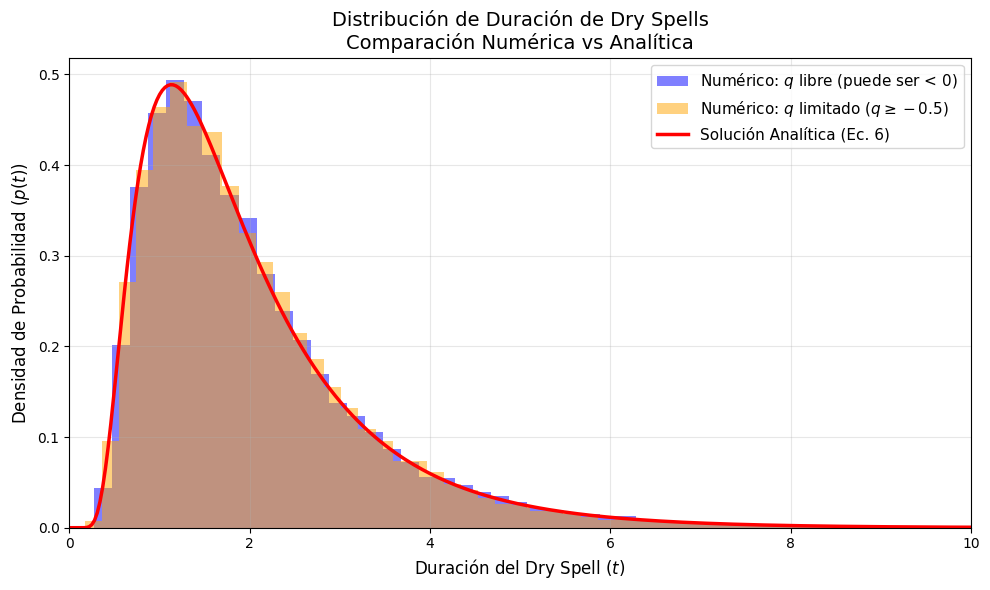

In [12]:
# ==========================================
# 4. GRÁFICOS Y COMPARACIÓN
# ==========================================
plt.figure(figsize=(10, 6))

# Histograma Caso 1: q libre (Debe coincidir con la analítica)
plt.hist(durations_unconstrained, bins=60, density=True, alpha=0.5, 
         color='blue', label='Numérico: $q$ libre (puede ser < 0)')

# Histograma Caso 2: q restringido (Muestra el efecto físico del límite)
plt.hist(durations_constrained, bins=60, density=True, alpha=0.5, 
         color='orange', label=f'Numérico: $q$ limitado ($q \geq {q_min}$)')

# Curva Analítica (Ecuación 6)
plt.plot(t_teo, pdf_teo, color='red', linewidth=2.5, 
         label='Solución Analítica (Ec. 6)')

plt.title('Distribución de Duración de Dry Spells\nComparación Numérica vs Analítica', fontsize=14)
plt.xlabel('Duración del Dry Spell ($t$)', fontsize=12)
plt.ylabel('Densidad de Probabilidad ($p(t)$)', fontsize=12)
plt.xlim(0, 10)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

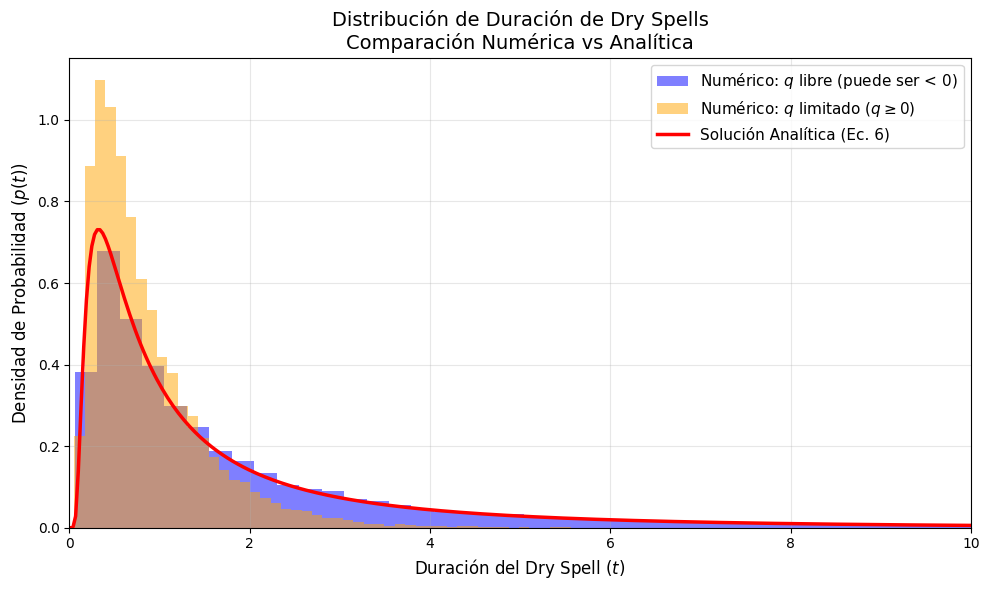